In [142]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Dataset loaders for different datasets
from sklearn.datasets import load_iris, load_wine, load_boston, load_breast_cancer, load_digits

# For hyperparameter search
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Different types of model
# Linear models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC

# Random forests, gradient-boosted trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Support vector machines
from sklearn.svm import SVC

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Normalize data
from sklearn.preprocessing import StandardScaler

In [98]:
# Make a list of models to try, as well as parameters to vary in cross-validation

models = [
    # Regularized linear models have either L1 or L2 norm penalty terms, with a coefficient that 
    # measures the strength of the regularization
     
    # L2 asks the components of the linear fit to be small
    # L1 asks the model to be sparse (components exactly zero if possible)
    #
    # Different methods correspond to different loss functions being optimized
    ( "Logistic Regression", LogisticRegression, { 'penalty': ['l1', 'l2'], 
                           'C': [1e-2,5e-2,1e-1,5e-1,1,5,10,50,100]} ),
    ( "Ridge Classifier", RidgeClassifier, {'alpha': [1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 50, 100]}),
    ( "Linear SVC", LinearSVC , { 'C': [1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 50, 100]} ),
    
    # Random forests make a bunch of different decision trees and do a weighted combination of their predictions
    # Primary hyperparameter n_estimators is how many different trees to use
    # max_depth is how deep the trees are (how many successive decisions) - can cause overfitting if large
    # RandomForestClassifier makes each tree fit to the data
    # ExtraTreesClassifier includes some 'totally random' decision trees
    # GradientBoostingClassifier constructs a hierarchy of models each explaining the residual error of the last
    ( "Decision Tree", DecisionTreeClassifier, {'criterion': ['gini', 'entropy'], 
                               'max_depth': [1,2,3,4,5,6,7,8], 
                               'min_samples_split': [2,4,8,16], 
                               'max_features': [0.1,0.2,0.4,0.6,0.8,1] } ),
    ( "Random Forest", RandomForestClassifier, {'n_estimators': [10,50,100,200,500,1000], 
                               'criterion': ['gini', 'entropy'], 
                               'max_depth': [1,2,3,4,5,6,7,8], 
                               'min_samples_split': [2,4,8,16], 
                               'max_features': [0.1,0.2,0.4,0.6,0.8,1]}),
    ( "Extra Trees", ExtraTreesClassifier, {'n_estimators': [10,50,100,200,500,1000], 
                             'criterion': ['gini', 'entropy'], 
                             'max_depth': [1,2,3,4,5,6,7,8], 
                             'min_samples_split': [2,4,8,16], 
                             'max_features': [0.1,0.2,0.4,0.6,0.8,1]}),
    ( "Gradient Boosting", GradientBoostingClassifier, {
                                   'n_estimators': [10,50,100,200,500,1000], 
                                   'max_depth': [1,2,3,4,5,6,7,8], 
                                   'min_samples_split': [2,4,8,16], 
                                   'max_features': [0.1,0.2,0.4,0.6,0.8,1], 
                                   'subsample': [0.6,0.8,0.9,0.95,1]}),
    
    # Support vector machines use a function space to model the decision boundary (so-called 'kernel trick')
    ( "Kernel SVC", SVC, {'C': [1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 50, 100], 
            'gamma': [1e-1, 2e-1, 5e-1, 7e-1, 1, 2, 5, 7, 10]}),
    
    # Naive Bayes
    ( "Naive Bayes", GaussianNB, {} )    
]

In [99]:
# There are a number of parameter combinations that will generate warnings that make it hard to 
# read the results as they are generated, so we'll suppress them
import warnings
warnings.simplefilter('ignore')

# Code to test every model
def testModelsCV(x, y):
    names = []
    scores = []
    hyperparams = []
    estimators = []
    
    for model in models:
        clf = model[1]()
        params = model[2]
        
        cv = RandomizedSearchCV(clf, params, n_iter = 30, cv = 10)
        cv.fit(x, y)
        
        scores.append(cv.best_score_)
        names.append(model[0])
        hyperparams.append(cv.best_params_)
        estimators.append(cv.best_estimator_)
        
        print("%s: %.6g" % (model[0], cv.best_score_))
    
    return names, scores, hyperparams, estimators

In [139]:
def plotDecisionBoundary(clf, x, y, feat1, feat2):
    x1 = x[:,feat1]
    x2 = x[:,feat2]
    
    # Make a grid of values to evaluate the classifier at
    xx,yy = np.meshgrid(np.arange(np.min(x1), np.max(x1), 0.01), np.arange(np.min(x2), np.max(x2), 0.01))
    RES = xx.shape
    
    zz = np.zeros((RES[0]*RES[1], x.shape[1]))
    for i in range(x.shape[1]):
        zz[:, i] = np.mean(x[:,i])
        
    zz[:,feat1] = xx.ravel()
    zz[:,feat2] = yy.ravel()
    
    p = clf.predict(zz)
    p = p.reshape((RES[0],RES[1]))
    
    plt.contourf(xx,yy,p, cmap=plt.cm.Spectral)
    plt.scatter(x[:,feat1], x[:,feat2], c=y, s=10, edgecolors='black', cmap=plt.cm.Spectral)

## Iris dataset

In [127]:
iris_data = load_iris()

x = iris_data['data']
y = iris_data['target']

# This data is not shuffled (labels are 0,0,0,0,...,1,1,1,1,...,2,2,2,2)
# So let's shuffle it with a fixed random seed
np.random.seed(12345)
idx = np.random.permutation(x.shape[0])

x = x[idx]
y = y[idx]

print("Dataset has %d rows, %d features" % (x.shape[0], x.shape[1]))

Dataset has 150 rows, 4 features


In [128]:
# Make a train/test split
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.3)
train_idx, test_idx = next(split.split(x,y))

x_train = x[train_idx]
y_train = y[train_idx]

x_test = x[test_idx]
y_test = y[test_idx]

In [129]:
# Normalize the data
# Note that we're only using the training set to avoid leakage

ss = StandardScaler()

x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [130]:
# Test out all of our different model possibilities
names, scores, hyperparams, estimators = testModelsCV(x_train, y_train)

Logistic Regression: 0.971429
Ridge Classifier: 0.828571
Linear SVC: 0.971429
Decision Tree: 0.961905
Random Forest: 0.961905
Extra Trees: 0.961905
Gradient Boosting: 0.952381
Kernel SVC: 0.971429
Naive Bayes: 0.952381


In [131]:
# Now try them all on the test set and see how the scores correlate with the cross-validation scores

test_scores = []

for i in range(len(estimators)):
    p = estimators[i].predict(x_test)
    score = np.mean(p==y_test)
    test_scores.append(score)
    
    print("%s: %.6g" % (names[i], score))

Logistic Regression: 0.955556
Ridge Classifier: 0.866667
Linear SVC: 0.933333
Decision Tree: 0.933333
Random Forest: 0.977778
Extra Trees: 0.955556
Gradient Boosting: 0.933333
Kernel SVC: 0.955556
Naive Bayes: 0.955556


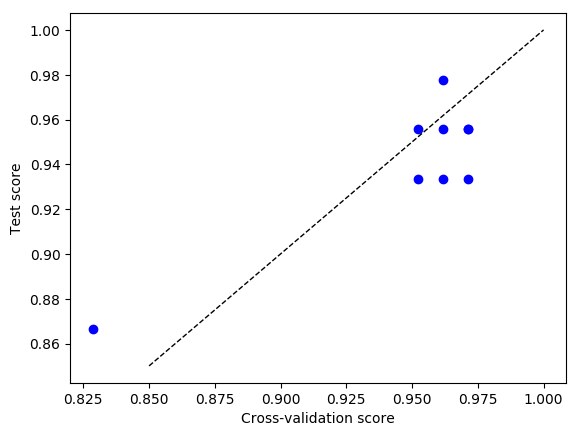

In [132]:
plt.plot(scores, test_scores, 'bo')
plt.plot(np.arange(0.85,1.04,0.05), np.arange(0.85,1.04,0.05), 'k--')
plt.xlabel("Cross-validation score")
plt.ylabel("Test score")
plt.show()

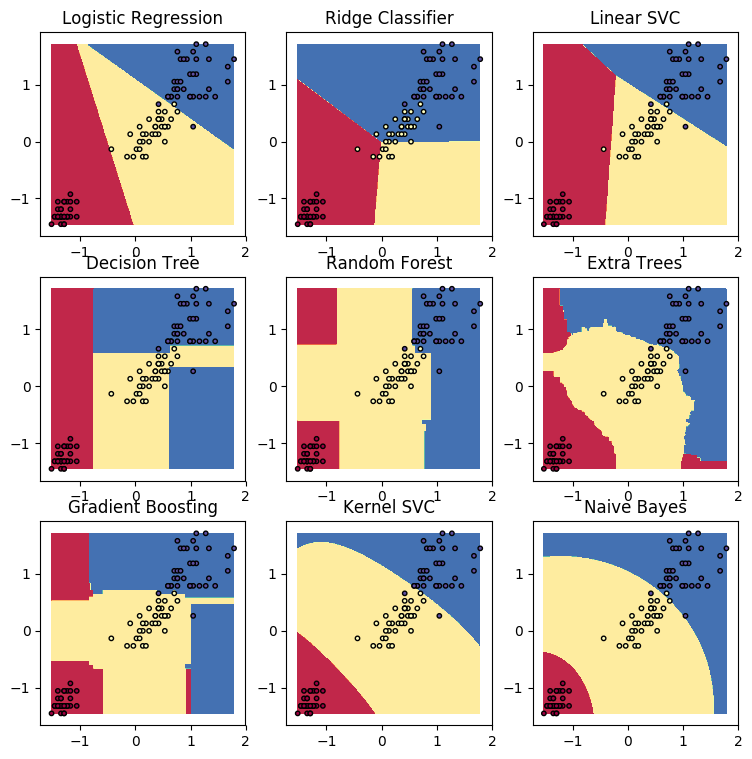

In [138]:
for i in range(len(estimators)):
    plt.subplot(3,3,1+i)
    plt.title("%s" % names[i])
    plotDecisionBoundary(estimators[i], x_train, y_train, 2, 3)
    
plt.gcf().set_size_inches((9,9))
plt.show()

## Wine dataset

In [140]:
wine_data = load_wine()

x = wine_data['data']
y = wine_data['target']

# This data is not shuffled (labels are 0,0,0,0,...,1,1,1,1,...,2,2,2,2)
# So let's shuffle it with a fixed random seed
np.random.seed(12345)
idx = np.random.permutation(x.shape[0])

x = x[idx]
y = y[idx]

print("Dataset has %d rows, %d features" % (x.shape[0], x.shape[1]))

Dataset has 178 rows, 13 features


In [141]:
# Make a train/test split
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.3)
train_idx, test_idx = next(split.split(x,y))

x_train = x[train_idx]
y_train = y[train_idx]

x_test = x[test_idx]
y_test = y[test_idx]

In [143]:
# Normalize the data
# Note that we're only using the training set to avoid leakage

ss = StandardScaler()

x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [144]:
# Test out all of our different model possibilities
names, scores, hyperparams, estimators = testModelsCV(x_train, y_train)

Logistic Regression: 0.983871
Ridge Classifier: 0.991935
Linear SVC: 0.983871
Decision Tree: 0.951613
Random Forest: 0.991935
Extra Trees: 0.991935
Gradient Boosting: 0.991935
Kernel SVC: 0.983871
Naive Bayes: 0.959677


In [145]:
# Now try them all on the test set and see how the scores correlate with the cross-validation scores

test_scores = []

for i in range(len(estimators)):
    p = estimators[i].predict(x_test)
    score = np.mean(p==y_test)
    test_scores.append(score)
    
    print("%s: %.6g" % (names[i], score))

Logistic Regression: 0.981481
Ridge Classifier: 0.981481
Linear SVC: 0.981481
Decision Tree: 0.814815
Random Forest: 0.981481
Extra Trees: 0.962963
Gradient Boosting: 0.981481
Kernel SVC: 0.981481
Naive Bayes: 0.962963


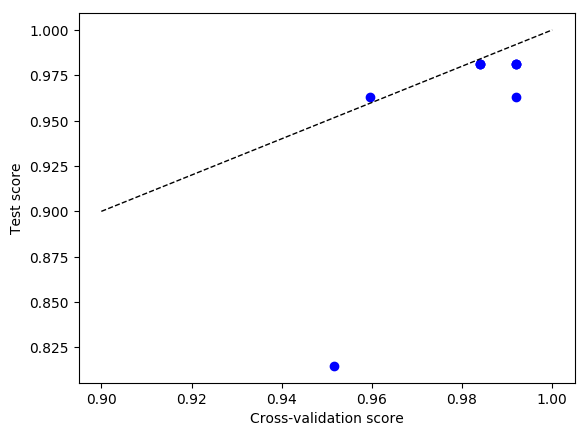

In [149]:
plt.plot(scores, test_scores, 'bo')
plt.plot(np.arange(0.9,1.04,0.05), np.arange(0.9,1.04,0.05), 'k--')
plt.xlabel("Cross-validation score")
plt.ylabel("Test score")
plt.show()

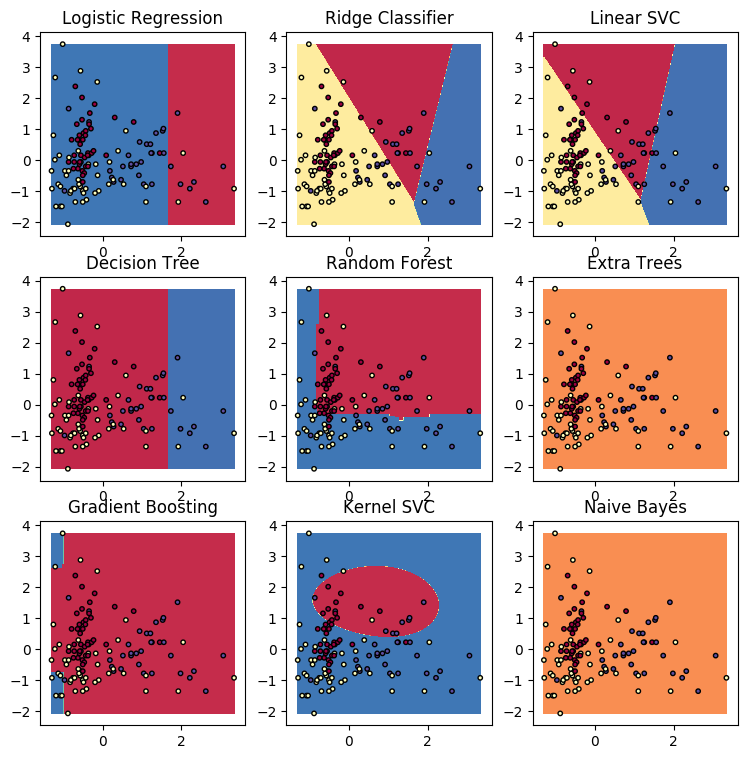

In [152]:
for i in range(len(estimators)):
    plt.subplot(3,3,1+i)
    plt.title("%s" % names[i])
    plotDecisionBoundary(estimators[i], x_train, y_train, 1, 4)
    
plt.gcf().set_size_inches((9,9))
plt.show()

## Breast Cancer Dataset

In [153]:
bc_data = load_breast_cancer()

x = bc_data['data']
y = bc_data['target']

# This data is not shuffled (labels are 0,0,0,0,...,1,1,1,1,...,2,2,2,2)
# So let's shuffle it with a fixed random seed
np.random.seed(12345)
idx = np.random.permutation(x.shape[0])

x = x[idx]
y = y[idx]

print("Dataset has %d rows, %d features" % (x.shape[0], x.shape[1]))

Dataset has 569 rows, 30 features


In [154]:
# Make a train/test split
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.3)
train_idx, test_idx = next(split.split(x,y))

x_train = x[train_idx]
y_train = y[train_idx]

x_test = x[test_idx]
y_test = y[test_idx]

In [155]:
# Normalize the data
# Note that we're only using the training set to avoid leakage

ss = StandardScaler()

x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [156]:
# Test out all of our different model possibilities
names, scores, hyperparams, estimators = testModelsCV(x_train, y_train)

Logistic Regression: 0.984925
Ridge Classifier: 0.952261
Linear SVC: 0.979899
Decision Tree: 0.949749
Random Forest: 0.969849
Extra Trees: 0.974874
Gradient Boosting: 0.977387
Kernel SVC: 0.954774
Naive Bayes: 0.932161


In [157]:
# Now try them all on the test set and see how the scores correlate with the cross-validation scores

test_scores = []

for i in range(len(estimators)):
    p = estimators[i].predict(x_test)
    score = np.mean(p==y_test)
    test_scores.append(score)
    
    print("%s: %.6g" % (names[i], score))

Logistic Regression: 0.976608
Ridge Classifier: 0.959064
Linear SVC: 0.976608
Decision Tree: 0.929825
Random Forest: 0.947368
Extra Trees: 0.947368
Gradient Boosting: 0.953216
Kernel SVC: 0.947368
Naive Bayes: 0.912281


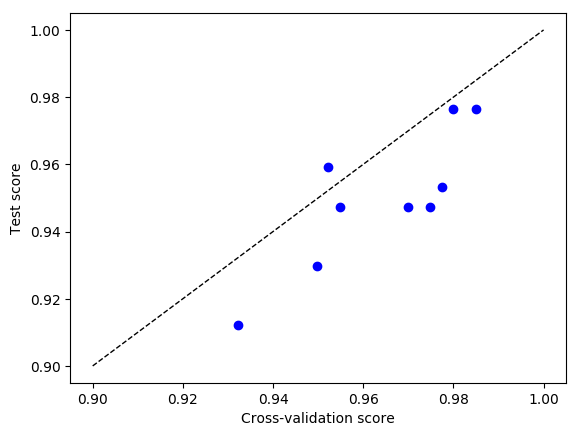

In [158]:
plt.plot(scores, test_scores, 'bo')
plt.plot(np.arange(0.9,1.04,0.05), np.arange(0.9,1.04,0.05), 'k--')
plt.xlabel("Cross-validation score")
plt.ylabel("Test score")
plt.show()